## Variational Zero-inflated Gaussian Processes in GPFlow

In [3]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import gpflow as gpf
import numpy as np
gpf.config.set_default_float(np.float32)

gpf.config.set_default_jitter(tf.cast(1e-6, dtype=gpf.default_float()))
from onoffgpf import OnOffSVGP, OnOffLikelihood
from onoffgpf.PlotOnOff1D import PlotOnOff1D

from gpflow.ci_utils import ci_niter

import gpflow

import scipy.io as sio
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
import copy

** Load simulated dataset **

In [4]:
matdata = sio.loadmat('data/toydata.mat')
Xtrain = matdata['x'].astype(gpf.default_float())
Ytrain = matdata['y'].astype(gpf.default_float())

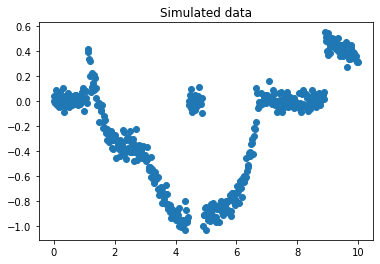

In [5]:
plt.scatter(Xtrain,Ytrain)
plt.title("Simulated data")
plt.show()

**Train specifications & variable initializations**

In [6]:
Xtrain[np.random.choice(range(len(Xtrain)), 10)]

array([[0.8908686],
       [4.788419 ],
       [0.6904232],
       [7.9287305],
       [7.7282853],
       [8.129176 ],
       [1.9153675],
       [7.3051224],
       [5.478842 ],
       [2.8507795]], dtype=float32)

In [7]:
num_iterations = 1000000
num_inducing   = 10

# initalize kernel parameters
kf = gpf.kernels.RBF(variance=1, lengthscales=2)
#kf.lengthscales = 2.
#kf.variance = 1.

kg = gpf.kernels.RBF(variance=5, lengthscales=2)
#kg.lengthscales = 2.
#kg.variance = 5.

# initialise equally spaced inducing point locations
Zf = []
Zg = []

#for i in range(10):
#    Zf.append(np.delete(np.linspace(min(Xtrain)+max(Xtrain)*.3*i/9,max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1))
#    Zg.append(np.delete(np.linspace(min(Xtrain)+max(Xtrain)*.3*i/9,max(Xtrain),num_inducing,endpoint=False),0).transpose().reshape(-1,1))


for i in range(10):
    random_points = Xtrain[np.random.choice(range(len(Xtrain)), 9)]
    Zf.append(copy.deepcopy(np.flip(np.sort(random_points))))
    Zg.append(copy.deepcopy(np.flip(np.sort(random_points))))

** Model build and training **

In [8]:
# model definition
models = []
for i in range(10):
    m = OnOffSVGP(copy.deepcopy(Xtrain), copy.deepcopy(Ytrain)
                  ,kernf=copy.deepcopy(kf),kerng=copy.deepcopy(kg)
                  ,likelihood = copy.deepcopy(OnOffLikelihood())
                  ,Zf = copy.deepcopy(Zf[i]),Zg = copy.deepcopy(Zg[i])
                 )

    # fix the model noise term
    m.likelihood.variance.assign(0.01)
    from gpflow import set_trainable
    set_trainable(m.likelihood.variance, True)
    models.append(copy.deepcopy(m))

minibatch_size = 100

N=len(Xtrain)

train_dataset = tf.data.Dataset.from_tensor_slices((tf.convert_to_tensor(Xtrain,),
                                                    tf.convert_to_tensor(Ytrain,)),)#.repeat().shuffle(N)

train_iter = iter(train_dataset)#batch(minibatch_size))


In [9]:
def run_adam(model, iterations):
    """
    Utility function running the Adam optimizer

    :param model: GPflow model
    :param interations: number of iterations
    """
    # Create an Adam Optimizer action
    logf = []
    train_iter = train_dataset#iter(train_dataset.batch(minibatch_size))
    training_loss = model.training_loss_closure(compile=True)
    
    

    @tf.function
    def optimization_step():
        optimizer.minimize(training_loss, model.trainable_variables)

    for step in range(iterations):
        optimization_step()
        if step % 10 == 0:
            elbo = -training_loss().numpy()
            logf.append(elbo)
    return logf

In [10]:
def my_callback_closure(model, history):
    def my_callback(step, variables, values):

        history.append(-model.training_loss())
        return
    return my_callback

In [11]:
maxiter = ci_niter(100000)
logs = []



for i in range(10):
    print(i)
    def run_adam(model, iterations):
        """
        Utility function running the Adam optimizer

        :param model: GPflow model
        :param interations: number of iterations
        """
        # Create an Adam Optimizer action
        logf = []
        train_iter = train_dataset#iter(train_dataset.batch(minibatch_size))
        training_loss = model.training_loss_closure(compile=True)
        optimizer = tf.optimizers.Adam(learning_rate=0.005)#gpflow.optimizers.Adam(learning_rate=0.01)

        #@tf.function
        #def optimization_step():
        #    optimizer.minimize(training_loss, model.trainable_variables)


        
        history=[]
        gpflow.optimizers.Scipy().minimize(
            model.training_loss,
            model.trainable_variables,
            options=dict(maxiter=iterations),
            tol=10e-10,
            method="L-BFGS-B",
            step_callback=my_callback_closure(model, history)
        )

        return history
    logf = run_adam(models[i], maxiter)
    logs.append(logf)

0
1
2
3
4
5
6
7
8
9


2022-08-22 14:30:49.931861: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2022-08-22 14:30:49.931931: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


In [ ]:
tfp.math.value_and_gradient(models[0].training_loss, models[0].trainable_variables)

In [10]:
#m.optimize(maxiter = num_iterations) #,method= tf.train.AdamOptimizer(learning_rate = 0.01)
m.compute_log_likelihood()

AttributeError: 'OnOffSVGP' object has no attribute 'compute_log_likelihood'

** Mode fit visualization **

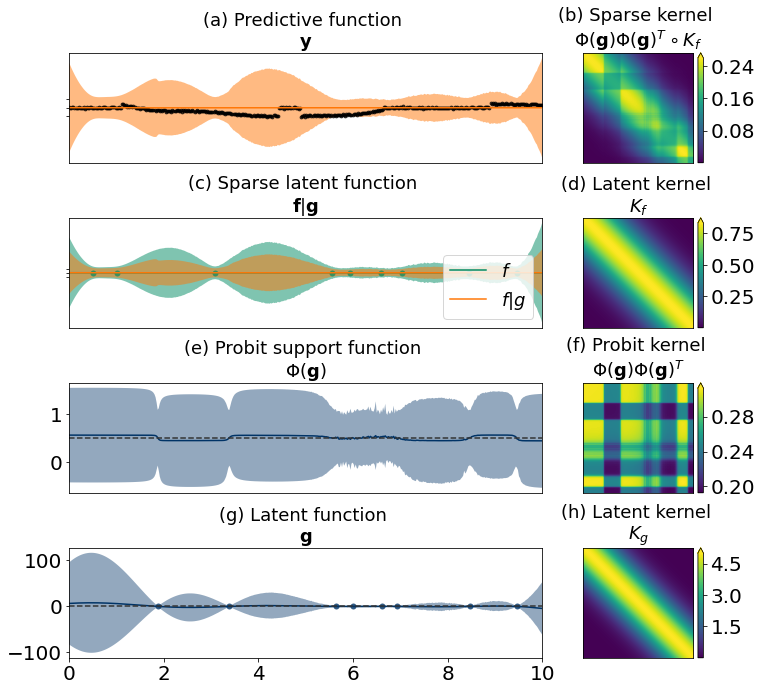

In [19]:
# model plot
PlotOnOff1D(models[0])

In [ ]:
Xtrain.shape

In [ ]:
from gpflow.config import default_jitter

In [ ]:
default_jitter()

In [ ]:
f.eye(m.num_inducing_f, dtype=float_type) * default_jitter()

In [ ]:
kf.K(Xtrain)

In [ ]:
default_float

In [ ]:
gpf.default_float()

In [ ]:
m.X.dtype

In [ ]:
m.Zf.numpy()

In [ ]:
m.likelihood.variance

In [ ]:
m.kernf.K(m.Xtrain)

In [ ]:
dir(m.kernf)

In [ ]:
import scipy
optimizer = tf.optimizers.Adam()
optimizer.minimize(
    m.training_loss_closure(),
    m.trainable_variables,
)

In [ ]:
m.training_loss_closure()

In [ ]:
m.trainable_variables

In [ ]:
m.training_loss()

In [ ]:
m

In [11]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(
    m.training_loss_closure(compile=True),
    m.trainable_variables,
    options=dict(maxiter=(80000),),tol=1e-16
)

      fun: nan
 hess_inv: <59x59 LbfgsInvHessProduct with dtype=float64>
      jac: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 22
      nit: 0
     njev: 22
   status: 2
  success: False
        x: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan])

In [ ]:
m.likelihood

In [ ]:
dir(m)

In [ ]:
m.likelihood

In [ ]:
m.Zf

In [ ]:
m.Zg

In [ ]:
Zf

In [ ]:
dir(m.kerng)

In [ ]:
m.kerng.variance

In [ ]:
m.kernf.lengthscales

In [ ]:
m.kerng

In [ ]:

from gpflow.utilities import print_summary

In [ ]:
print_summary(kg)

In [ ]:
m.log_posterior_density

In [ ]:
plt.plot(range(len(logf)), logf)
plt.ylim(-200,600)

(-200.0, 600.0)

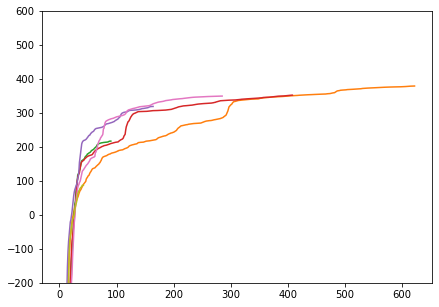

In [12]:
plt.figure(figsize=(7,5))
for i in range(10):
    plt.plot(range(len(logs[i])), logs[i])
plt.ylim(-200,600)



In [1]:
logs[2]

NameError: name 'logs' is not defined

In [ ]:
models[3]

In [ ]:
models[0].trainable_variables

In [ ]:
Zf[0].shape

In [ ]:
Zf[0]

In [ ]:
Zg[0]

In [ ]:
train_dataset.numpy

In [30]:
logs[2][-1]

nan

In [22]:
logs[0]

[-40850296.0,
 -23891776.0,
 -16144235.0,
 -8316679.5,
 -4540242.0,
 -3129511.8,
 -2501434.8,
 -2172388.5,
 -1712907.0,
 -1382694.9,
 -1282322.5,
 -1085117.8,
 -1629959.0,
 -968924.9,
 -1147661.8,
 -981690.75,
 -752198.1,
 -1387635.8,
 -1313097.5,
 -1091603.5,
 -804336.7,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 

tf.Tensor(-283.5715, shape=(), dtype=float32)


      fun: -283.571533203125
 hess_inv: <59x59 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.87866592, -0.03302877,  1.06382275,  0.61801982,  3.50737953,
       -0.1791358 , -0.88323867,  0.83019543, -1.00986576, -1.57538676,
       -0.06362183,  3.79833984,  1.64777565,  0.44523048, -3.66387939,
        1.7323643 ,  1.19515991,  0.65472603, -0.88959503, -0.16962862,
       -0.64253426,  2.64337754, -2.59390259,  1.16432381,  1.20025253,
        2.36315727, -0.38296604, -0.32760698, -0.05951637, -0.35508507,
        0.39082921,  0.40543896, -0.20034742, -0.24652952, -0.27063942,
       -0.3712002 , -0.02750972,  0.02521749, -0.53338623, -0.5249837 ,
       -0.30605948,  0.38827896, -0.25498977, -0.0298171 , -0.46111107,
       -0.47349504, -0.39523062,  0.06625372, -0.6911028 ,  0.10055143,
        0.17414206, -0.46976304,  0.09281373, -0.73626417,  1.89471245,
       -0.08837891, -1.0539093 , -2.1183548 , -0.36061096])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FAC

In [14]:
logs

[[], [], [], [], [], [], [], [], [], []]